In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# search window size, the window size was selected as different samples in the paper for comparsion
# half windows_size
ws = 20

# Method

## Side-scan sonar sequence

./data/20120830150809.xtf is read!


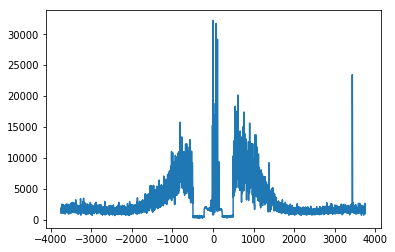

In [2]:
import xtf
from xtf import XTF_Parser
import numpy as np
import matplotlib.pyplot as plt

fujian = r'./data/20120830150809.xtf'

xtf_parser = XTF_Parser(fujian)
xtf_parser.parse()

ping = xtf_parser.parse_SSS_packet(0)
channel = len(ping)


# Show one ping
ping_id = 100
ping = xtf_parser.parse_SSS_packet(ping_id)

if ping_id > xtf_parser.packet_type_nums[xtf_parser.packet_type.index(xtf.XTF_HEADER_SONAR)]:
    print("ping id out range!")

# show in subplots ping
t = np.arange(0, len(ping['PORT_LF']))

plt.figure()
if channel == 2:  
    t = np.arange(0, len(ping['PORT_LF']))
    bsbs = np.append(ping['PORT_LF'], ping['STBD_LF'][1:])
    tt = np.append(np.flip(-t), t[1:])
    plt.plot(tt[1::1], bsbs[1::1])
    
    plt.show()
if channel == 4:
    plt.subplot(211)
    plt.plot(t, np.flip(ping['PORT_HF'], 0))
    plt.subplot(212)
    plt.plot(t, ping['STBD_HF'])
    plt.show()

## load seabed ids (using other method)

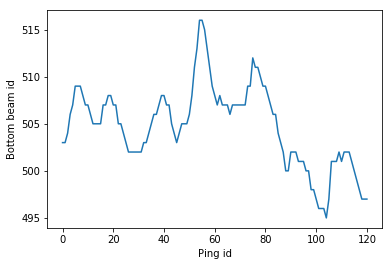

In [3]:
label = np.genfromtxt('./data/20120830150809.csv', delimiter=",")
label = label.reshape((label.size, 1))

plt.plot(label[0:len(label):1])
plt.xlabel('Ping id')
plt.ylabel('Bottom beam id')
plt.show()

## Showing differenct region sequence

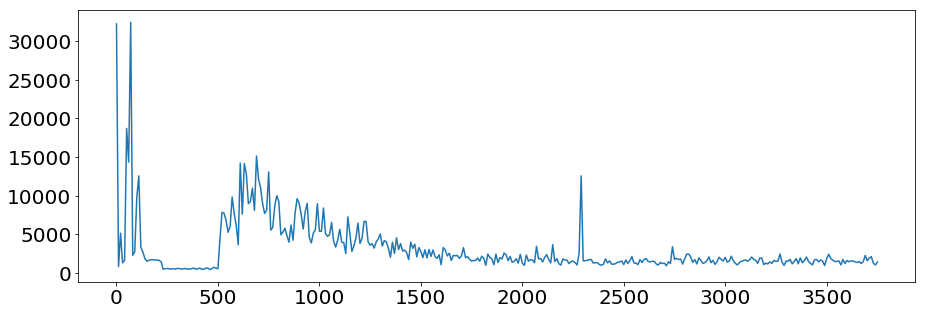

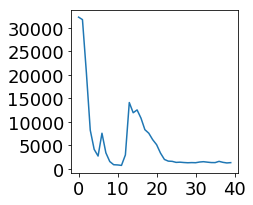

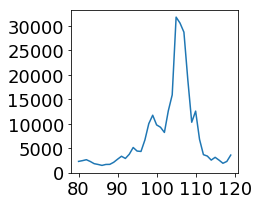

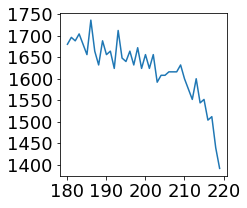

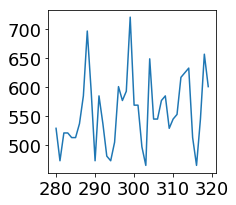

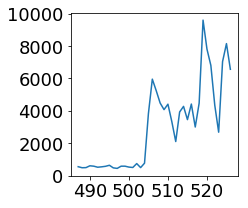

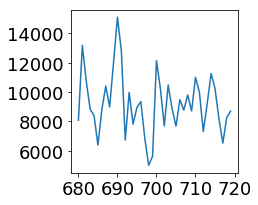

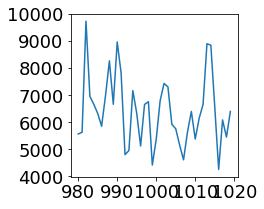

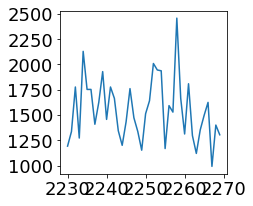

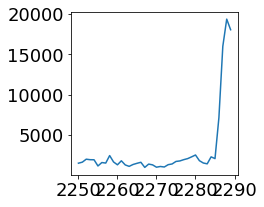

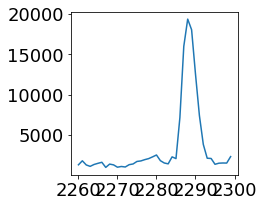

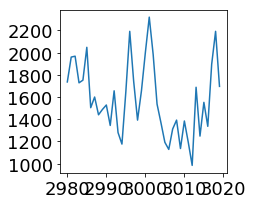

In [4]:
'''Show one ping'''
ping_id = 10
ping = xtf_parser.parse_SSS_packet(ping_id)

if ping_id > xtf_parser.packet_type_nums[xtf_parser.packet_type.index(xtf.XTF_HEADER_SONAR)]:
    print("ping id out range!")

# show in subplots ping
t = np.arange(0, len(ping['PORT_LF']))

plt.figure(figsize=(15, 5))
if channel == 2:
    plt.plot(t[0::10], ping['STBD_LF'][0::10])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

csi = int(label[ping_id])


# plt.figure(figsize=(3, 3))
for csi in [20, 100, 200, 300, csi, 700, 1000, 2250, 2270, 2280, 3000]:
    plt.figure(figsize=(3, 3))
    plt.plot(t[csi - ws: csi + ws], ping['STBD_LF'][csi - ws: csi + ws])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Normalization

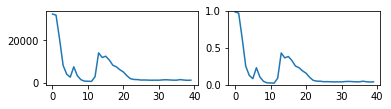

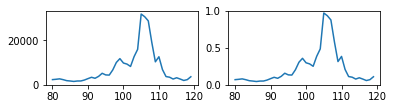

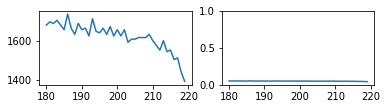

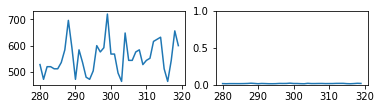

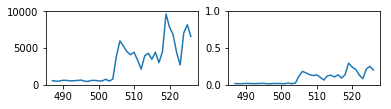

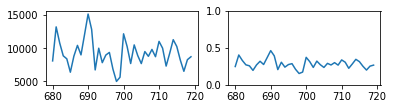

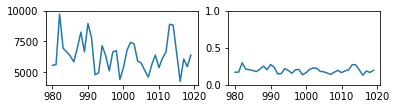

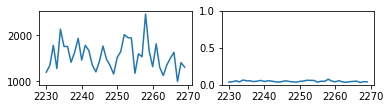

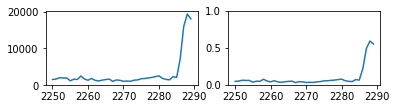

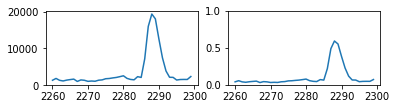

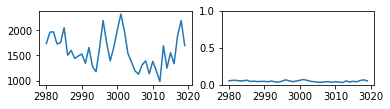

In [5]:
csi = int(label[ping_id])
z = np.array(ping['STBD_LF']) / 32768.


for csi in [20, 100, 200, 300, csi, 700, 1000, 2250, 2270, 2280, 3000]:

    plt.figure(figsize=(6, 3))
    plt.subplot(221)
    plt.plot(t[csi - ws: csi + ws], ping['STBD_LF'][csi - ws: csi + ws])

    plt.subplot(222)
    plt.ylim(0,1)
    plt.plot(t[csi - ws: csi + ws], z[csi - ws: csi + ws])

    plt.show()

## Sample generation (demo)
Use raw data to generate true and false data sequence samples 
Better manually select the samples

Generate true sample

In [6]:
import os

true_samples_dir = './.Samples/True'

if not os.path.exists(true_samples_dir):
    os.makedirs('./.Samples/')
    os.makedirs(true_samples_dir)

# Ture samples
for id in range(xtf_parser.packet_type_nums[xtf_parser.packet_type.index(xtf.XTF_HEADER_SONAR)]):
    ping = xtf_parser.parse_SSS_packet(id)

    csi = int(label[id])

    port_sample = np.flip(ping['PORT_LF'], 0)[csi - ws: csi + ws]
    stbd_sample = ping['STBD_LF'][csi - ws: csi + ws]


    np.savetxt(fr'{true_samples_dir}/{id}_PORT_LF.txt', port_sample, fmt='%.0f')
    np.savetxt(fr'{true_samples_dir}/{id}_STBD_LF.txt', stbd_sample, fmt='%.0f')

Generate false sample

In [7]:
false_samples_dir = './.Samples/False'

if not os.path.exists(false_samples_dir):
    os.makedirs(false_samples_dir)

num = 0
for id in range(xtf_parser.packet_type_nums[xtf_parser.packet_type.index(xtf.XTF_HEADER_SONAR)]):
    ping = xtf_parser.parse_SSS_packet(id)

    csi = int(label[id])

    for csi in [100, 150, 200, 350, 600, 700, 1000, 1500, 1800]: # for examples, random may be better
        port_sample = np.flip(ping['PORT_LF'], 0)[csi - ws: csi + ws]
        stbd_sample = ping['STBD_LF'][csi - ws: csi + ws]

        np.savetxt(fr'{false_samples_dir}/{num}_PORT_LF.txt', port_sample, fmt='%.0f')
        np.savetxt(fr'{false_samples_dir}/{num}_STBD_LF.txt', stbd_sample, fmt='%.0f')
        num = num + 1

# Net (different nets for comparison)

In [8]:
from keras import layers
from keras import models
from keras import optimizers


model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(ws * 2, 1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
# model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
          
model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 38, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 64)            6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 128)            24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
flat

## Data import

In [9]:
import os 

true_samples_dir = f'./Samples/True'
false_samples_dir =f'./Samples/False'

num_true_samples = len(os.listdir(true_samples_dir))
num_false_samples = len(os.listdir(false_samples_dir))
print(num_true_samples)
print(num_false_samples)


train_data = []
for file in os.listdir(true_samples_dir):
    sample_data = np.genfromtxt(true_samples_dir + '/' + file)
    train_data.append(sample_data)

for file in os.listdir(false_samples_dir):
    sample_data = np.genfromtxt(false_samples_dir + '/' + file)
    train_data.append(sample_data)


label_data = np.ones(num_true_samples)    # label 1
label_data2 = np.zeros(num_false_samples) # label 0
labels = np.concatenate((label_data, label_data2), 0)

num_total = num_true_samples + num_false_samples
trainn = np.reshape(train_data, (num_total, ws * 2, 1))
trainn = trainn / np.max(trainn)
labell = np.reshape(labels, (num_total, 1))

242
2662


## CHECK IMPORT DATA

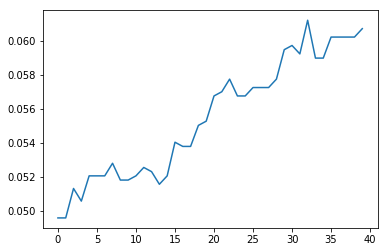

1.0

In [10]:
plt.plot(trainn[300])
plt.show()
np.max(trainn)

# Trainnig

In [11]:
history = model.fit(trainn, labell, epochs=20, batch_size=32, validation_split=0.2)

model.save(f'seabed_detection_t_{ws * 2}.h5')

Instructions for updating:
Use tf.cast instead.
Train on 2323 samples, validate on 581 samples
Epoch 1/20
2323/2323 [==============================] - 3s 1ms/step - loss: 0.5833 - acc: 0.8958 - val_loss: 0.3752 - val_acc: 1.0000
Epoch 2/20
2323/2323 [==============================] - 0s 137us/step - loss: 0.3787 - acc: 0.8958 - val_loss: 0.1446 - val_acc: 1.0000
Epoch 3/20
2323/2323 [==============================] - ETA: 0s - loss: 0.3221 - acc: 0.896 - 0s 128us/step - loss: 0.3238 - acc: 0.8958 - val_loss: 0.1131 - val_acc: 1.0000
Epoch 4/20
2323/2323 [==============================] - 0s 142us/step - loss: 0.3001 - acc: 0.8958 - val_loss: 0.1025 - val_acc: 1.0000
Epoch 5/20
2323/2323 [==============================] - 0s 140us/step - loss: 0.2709 - acc: 0.8958 - val_loss: 0.0962 - val_acc: 1.0000
Epoch 6/20
2323/2323 [==============================] - 0s 136us/step - loss: 0.2347 - acc: 0.8958 - val_loss: 0.0754 - val_acc: 1.0000
Epoch 7/20
2323/2323 [==============================]

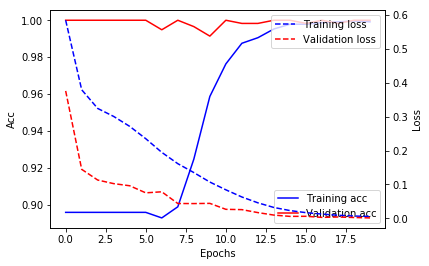

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

ax1 = plt.subplot()

ax1.plot(epochs, acc, 'b-', label='Training acc')
ax1.plot(epochs, val_acc, 'r-', label='Validation acc')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Acc')

ax2 = ax1.twinx()

ax2.plot(epochs, loss, 'b--', label='Training loss')
ax2.plot(epochs, val_loss, 'r--', label='Validation loss')
ax2.legend()
ax2.set_ylabel('Loss')
plt.show()

np.savetxt(f'acc{ws*2}.txt', acc, fmt='%10.5f')

# Detect the seabed using the Net

### using auto searching ranges to improve the speed

In [13]:
import time

def predict_ping_side(cnn_model, half_ping, start_beam_id=0, stop_beam_id=-1):
    """
    predict_ping_side port or stbd
    """

    # check the start and stop range
    if start_beam_id < 20:
        start_beam_id = 20
    if stop_beam_id > len(half_ping):
        stop_beam_id = len(half_ping)

    beam_id = start_beam_id
    if stop_beam_id < 0:
        stop_beam_id = len(half_ping)
    results = []
    while 1:
        sample = half_ping[beam_id - 20: beam_id + 20]

        if beam_id - 20 < 0:
            beam_id = beam_id + 1
            # results.append(-1)
            continue
        if beam_id + 20 >= len(half_ping):
            beam_id = beam_id + 1
            break

        ndata = np.reshape(sample, (1, 40, 1)) / 65536.  # normalized data

        # Predict
        ylabel = cnn_model.predict(ndata)
        results.append(ylabel[0])

        beam_id = beam_id + 1
        if beam_id >= stop_beam_id:
            break

    return np.array(results)


def predict_ping_auto_range2(fn, cnn_model, init_search_id, search_window=50, silent=True):
    """
    version 3
    """
    xtf_parser = XTF_Parser(fn)
    xtf_parser.parse()
    n_ping = xtf_parser.packet_type_nums[xtf_parser.packet_type.index(xtf.XTF_HEADER_SONAR)]

    print(f"Ping Num is : {n_ping}")
    pre_res = np.zeros(n_ping) - 1
    pre_res[-1] = init_search_id # -1 for error calculation
    time_last = time.time()
    time_spends = np.zeros(n_ping)

    port_res = np.zeros(n_ping)
    stbd_res = np.zeros(n_ping)

    n_error = 0
    n_missing= 0

    for pid in range(n_ping):
        port_sid = init_search_id
        stbd_sid = init_search_id

        if not silent:
            print(f'{pid}: ', end='\t')

        ping = xtf_parser.parse_SSS_packet(pid)

        # port data processing
        ping_port = np.flip(ping['PORT_LF'], 0)
        if len(ping_port) == 0:
            n_missing = n_missing + 1
            continue
        res_port = predict_ping_side(cnn_model, ping_port, port_sid - search_window,
                                     port_sid + search_window)
        port_res[pid] = np.argmax(res_port) + port_sid - search_window
        port_diff = port_res[pid] - port_sid
        port_sid = int(port_res[pid])

        if not silent:
            print(f'port {port_res[pid]} {np.max(res_port):.2}', end='\t')

        # stbd data processing
        ping_stbd = ping['STBD_LF']
        if len(ping_stbd) == 0:
            n_missing = n_missing + 1
            continue
        res_stdb = predict_ping_side(cnn_model, ping_stbd, stbd_sid - search_window,
                                     stbd_sid + search_window)
        stbd_res[pid] = np.argmax(res_stdb) + stbd_sid - search_window
        stdb_diff = stbd_res[pid] - stbd_sid
        stbd_sid = int(stbd_res[pid])
        if not silent:
            print(f'stbd {stbd_res[pid]} {np.max(res_stdb):.2}', end='\t')

        # check
        det = int((port_sid + stbd_sid) / 2)
        if np.max(res_port) < 0.5 and np.max(res_stdb) < 0.5: # seem regonition error
            # n_error = n_error + 1
            det = init_search_id
            search_window = 50
            pre_res[pid] = det
            continue
        else:
            if abs(port_sid - stbd_sid) < search_window / 2 :
                det = int((port_sid + stbd_sid) / 2)
                # n_error = n_error + 1
            else:
                if np.max(res_port) > np.max(res_stdb):
                    det = port_sid
                    n_error = n_error + 0.5
                else:
                    det = stbd_sid
                    n_error = n_error + 0.5

        if not silent:
            print(f'Overall {det}', end='\t')

        time_spends[pid] = time.time() - time_last

        if not silent:
            print('time used: {:.3f}s'.format(time_spends[pid] ), end='\t')

        time_last = time.time()

        in_step = abs(init_search_id - det)
        search_window = (in_step // 5 + 1) * 20
        if search_window > 100:
            search_window = 100

        if not silent:
            print(f'search window {search_window}')

        if silent:
            print(f'current: {pid}/{n_ping}', end='\r', flush=True)

        pre_res[pid] = det
        init_search_id = det  # update init_search_id

    print()
    np.savetxt(f'{fn[-10:-4]}_auto.txt', pre_res, fmt='%d')
    np.savetxt(f'{fn[-10:-4]}_auto_st.txt', time_spends * 1000, fmt='%d')
    print(f'save file {fn[-10:-4]}_{search_window}.txt')

    print(f'missing ping number: {n_missing}, acc rate {n_missing / n_ping}')
    print(f'err number: {n_error}, acc rate {(n_ping - n_error) / n_ping}')

    return pre_res

# Prediction

In [14]:
fn = r'./data/20120830150809.xtf'
cnn_model = models.load_model(f'seabed_detection_t_{ws*2}.h5')
init_search_id = 503
res = predict_ping_auto_range2(fn, cnn_model, init_search_id, 50, False)

./data/20120830150809.xtf is read!
Ping Num is : 121
0: 	port 503.0 0.92	stbd 503.0 0.39	Overall 503	time used: 0.291s	search window 20
1: 	port 502.0 0.9	stbd 503.0 0.32	Overall 502	time used: 0.083s	search window 20
2: 	port 504.0 0.89	stbd 506.0 0.35	Overall 505	time used: 0.078s	search window 20
3: 	port 506.0 0.86	stbd 506.0 0.22	Overall 506	time used: 0.085s	search window 20
4: 	port 507.0 0.98	stbd 508.0 0.21	Overall 507	time used: 0.079s	search window 20
5: 	port 508.0 0.93	stbd 509.0 0.38	Overall 508	time used: 0.078s	search window 20
6: 	port 508.0 0.89	stbd 510.0 0.35	Overall 509	time used: 0.085s	search window 20
7: 	port 509.0 0.97	stbd 510.0 0.54	Overall 509	time used: 0.080s	search window 20
8: 	port 508.0 0.91	stbd 508.0 0.61	Overall 508	time used: 0.084s	search window 20
9: 	port 507.0 0.96	stbd 510.0 0.54	Overall 508	time used: 0.087s	search window 20
10: 	port 506.0 0.94	stbd 505.0 0.79	Overall 505	time used: 0.081s	search window 20
11: 	port 506.0 0.95	stbd 505.0 0.

97: 	port 500.0 0.84	stbd 499.0 0.98	Overall 499	time used: 0.128s	search window 20
98: 	port 499.0 0.91	stbd 497.0 0.99	Overall 498	time used: 0.099s	search window 20
99: 	port 499.0 0.96	stbd 497.0 0.98	Overall 498	time used: 0.095s	search window 20
100: 	port 499.0 0.85	stbd 495.0 0.97	Overall 497	time used: 0.103s	search window 20
101: 	port 497.0 0.91	stbd 495.0 0.98	Overall 496	time used: 0.097s	search window 20
102: 	port 498.0 0.96	stbd 497.0 0.98	Overall 497	time used: 0.112s	search window 20
103: 	port 494.0 0.79	stbd 495.0 0.97	Overall 494	time used: 0.122s	search window 20
104: 	port 496.0 0.94	stbd 496.0 0.9	Overall 496	time used: 0.109s	search window 20
105: 	port 498.0 0.95	stbd 499.0 0.95	Overall 498	time used: 0.087s	search window 20
106: 	port 501.0 0.96	stbd 500.0 0.93	Overall 500	time used: 0.091s	search window 20
107: 	port 501.0 0.94	stbd 499.0 0.87	Overall 500	time used: 0.093s	search window 20
108: 	port 502.0 0.96	stbd 500.0 0.96	Overall 501	time used: 0.098s	s